# Train and evaluate CNN models



Author: Akash Kharita

Date: 02/28/2024

Modified by Marine Denolle on 06/20/24


### Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
# from tqdm import tqdm
from glob import glob
# import time
import random
import sys
from datetime import datetime

from scipy import stats,signal


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset



# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Parameters

### Waveform data

In [2]:
#data files
file_noise="/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

### Waveform Metadata

In [3]:
# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]


### Data Prep

In [4]:
start=-50
input_window_length=100 # in seconds
fs=50 # target sampling rate

number_data_per_class=2000 # number of data samples per class
num_channels=3  # number of components to check

SNR_THR = 15

all_data=False
shifting=True


# training parameters
train_split = 70
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()

##  Define models

In [5]:
# defining a very simple CNN
        
class MyCNN(nn.Module):
    def __init__(self, num_classes=4, num_channels = 3,dropout_rate=0.2):
        super(MyCNN, self).__init__()
        # Define the layers of the CNN architecture
        self.conv1 = nn.Conv1d(in_channels= num_channels, out_channels=8, kernel_size=9,stride=1,padding='same')
        self.conv2 = nn.Conv1d(in_channels= 8, out_channels=8, kernel_size=9,stride=2,padding=4)       
        self.conv3 = nn.Conv1d(in_channels= 8, out_channels=16, kernel_size=7,stride=1,padding='same')
        self.conv4 = nn.Conv1d(in_channels= 16, out_channels=16, kernel_size=7,stride=2,padding=3)        
        self.conv5 = nn.Conv1d(in_channels= 16, out_channels=32, kernel_size=5,stride=1,padding='same')
        self.conv6 = nn.Conv1d(in_channels= 32, out_channels=32, kernel_size=5,stride=2,padding=2)                
        self.conv7 = nn.Conv1d(in_channels= 32, out_channels=64, kernel_size=3,stride=1,padding='same')
        
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # batch-normalization layers
        self.bn1 = nn.BatchNorm1d(8)#, dtype=torch.float64)
        self.bn2 = nn.BatchNorm1d(8)#, dtype=torch.float64)
        self.bn3 = nn.BatchNorm1d(16)#, dtype=torch.float64)
        self.bn4 = nn.BatchNorm1d(16)#, dtype=torch.float64)
        self.bn5 = nn.BatchNorm1d(32)#, dtype=torch.float64)
        self.bn6 = nn.BatchNorm1d(32)#, dtype=torch.float64)
        self.bn7 = nn.BatchNorm1d(64)#, dtype=torch.float64)
        
        # self.fc1 = nn.Linear(5000, 128)  # Adjust input size based on your data
        self.fc1 = nn.Linear(4992, 128)  # Adjust input size based on your data
        self.fc2 = nn.Linear(128,num_classes)  # Adjust input size based on your data
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(num_classes)
        
        
        # Calculate the input size for the first fully connected layer
        # fc_input_size = self._get_conv_output_size(num_channels, 5000)
        
        # define dropout
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) # feature extraction, output size of 8,5000
        x = self.pool1(F.relu(self.bn2(self.conv2(x)))) # feature extraction, output size of 8,1250 
        x = self.dropout(x)
        # max pooling is done at this point, but after the 2 convolutions to avoid aliasing
        x = F.relu(self.bn3(self.conv3(x))) # feature extraction, output size of 16,1250
        x = self.pool1(F.relu(self.bn4(self.conv4(x)))) # feature extraction, output size of 16, 312
        x = self.dropout(x)
        x =  F.relu(self.bn5(self.conv5(x))) # feature extraction, output size of 32, 312
        x = self.pool1(F.relu(self.bn6(self.conv6(x)))) # feature extraction, output size of 32, 78
        x = self.dropout(x)
        x = F.relu(self.bn7(self.conv7(x))) # feature extraction, output size of 64, 78            
        x = x.view(x.size(0), -1) # Flatten before fully connected layer, 4992 features!
        x = self.dropout(x)
        x = F.relu(self.fc1_bn(self.fc1(x)))  # classifier
        x = self.fc2_bn(self.fc2(x)) # classifier
        # do not apply softmax here, as it will be applied in the loss function
        
        return x

In [6]:

class SeismicCNN(nn.Module):
    def __init__(self, num_classes=4, num_channels = 3,dropout_rate=0.2):
        super(SeismicCNN, self).__init__()
        # Define the layers of the CNN architecture
        self.conv1 = nn.Conv1d(in_channels= num_channels, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(79808, 128)  # Adjust input size based on your data
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

        self.dropout = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm1d(32)#, dtype=torch.float64)
        self.bn2 = nn.BatchNorm1d(64)#, dtype=torch.float64)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(num_classes)

    def forward(self, x):

        # x = self.pool1(F.relu(self.bn2(self.conv2(x)))) # feature extraction, output size of 8,1250 
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2_bn(self.fc2(x))
        # do not apply softmax here, as it will be applied in the loss function
        return x

    # Lets define a function to visualize the activation as well. 
    

In [7]:
class BasicResNetBlock(nn.Module):
    def __init__(self, in_channels):
        super(BasicResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(in_channels)
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = F.relu(out)
        
        return out

In [8]:
class MyResCNN(nn.Module):
    def __init__(self, num_classes, num_channels=3,dropout_rate=0.2):
        super(MyResCNN, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Add ResNet blocks
        self.layer1 = BasicResNetBlock(64)
        self.layer2 = BasicResNetBlock(64)
        
        # Example of additional layers
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):

        x = self.maxpool(F.relu(self.bn1(self.conv1(x)))) # feature extraction, output size of 8,5000
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # do not apply softmax here, as it will be applied in the loss function
        return x

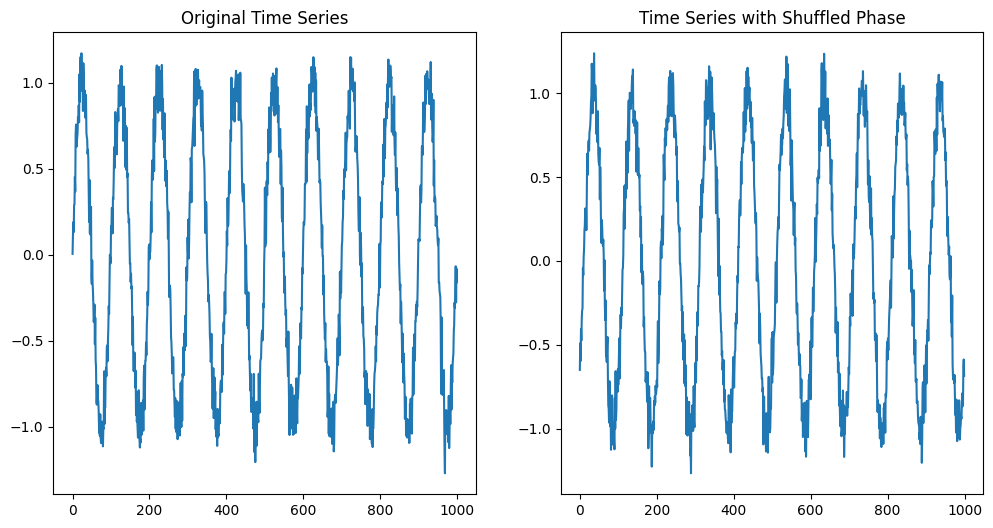

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def shuffle_phase_tensor(time_series):
    # Compute the Fourier transform
    new_time_series = torch.zeros(time_series.shape)
    for ichan in range(time_series.shape[0]):
        fourier_tensor = torch.fft.fft(torch.tensor(time_series[ichan,:]).float())
        # Get amplitude and phase
        amp_tensor = torch.abs(fourier_tensor)
        phase_tensor = torch.angle(fourier_tensor)
        
        # Shuffle the phase
        indices = torch.randperm(phase_tensor.size(-1)) 
        # in torch
        phase_tensor[1:len(phase_tensor)//2] = phase_tensor[indices[1:len(phase_tensor)//2]]
        phase_tensor[len(phase_tensor)//2+1:] = -torch.flip(phase_tensor[len(phase_tensor)//2+1:],dims=[0])  # Ensure conjugate symmetry
        
        # Reconstruct the Fourier transform with original amplitude and shuffled phase
        shuffled_fourier_tensor = amp_tensor * torch.exp(1j * phase_tensor)
        
        # Perform the inverse Fourier transform
        new_time_series[ichan,:] = torch.fft.ifft(shuffled_fourier_tensor).real


        window_length = new_time_series[ichan,:].size(-1)  # Taper along the last dimension
        hann_window = torch.hann_window(window_length).to(new_time_series.device)  # Ensure window is on the same device as tensor
        new_time_series[ichan,:] *= hann_window
    
    return new_time_series  # Return the real part



def shuffle_phase(time_series):
    # Compute the Fourier transform
    fourier_transform = np.fft.fft(time_series)
    
    # Get amplitude and phase
    amplitude = np.abs(fourier_transform)
    phase = np.angle(fourier_transform)
  
    # in numpy
    np.random.shuffle(phase[1:len(phase)//2])
    phase[len(phase)//2+1:] = -phase[len(phase)//2-1:0:-1]  # Ensure conjugate symmetry
    # in torch
    # Reconstruct the Fourier transform with original amplitude and shuffled phase
    shuffled_fourier = amplitude * np.exp(1j * phase)
    
    # Perform the inverse Fourier transform
    new_time_series = np.fft.ifft(shuffled_fourier)
    
    return new_time_series.real  # Return the real part


# Example usage
time_series = np.sin(np.linspace(0, 20*np.pi, 1000)) + np.random.normal(0, 0.1, 1000)
new_time_series = shuffle_phase(time_series)

# Plot the original and new time series
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(time_series)
plt.title('Original Time Series')
plt.subplot(1, 2, 2)
plt.plot(new_time_series)
plt.title('Time Series with Shuffled Phase')
plt.show()

### test CNN

In [10]:
# Assuming the input shape is (batch_size, num_channels, num_features)
# batch_size = 64  # You can adjust the batch size as needed
num_channels = 3
num_features = 5000
# Create a random input tensor with the specified shape
random_input = torch.randn(batch_size, num_channels,int(input_window_length*fs)).to(device)
# Initialize your model
model = SeismicCNN(num_classes=4, num_channels=num_channels).to(device)  # Use 'cuda' if you have a GPU available
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters in SeismicCNN in log10: {np.log10(total_params)}")
# Initialize your model
model2 = MyCNN(num_classes=4, num_channels=num_channels).to(device)  # Use 'cuda' if you have a GPU available
total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"Total number of parameters in MyCNN in log10: {np.log10(total_params)}")

# Initialize your model
model3 = MyResCNN(num_classes=4, num_channels=num_channels).to(device)  # Use 'cuda' if you have a GPU available
total_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f"Total number of parameters in MyResCNN in log10: {np.log10(total_params)}")


Total number of parameters in SeismicCNN in log10: 7.009762693972353
Total number of parameters in MyCNN in log10: 5.818038406899838
Total number of parameters in MyResCNN in log10: 4.710929320444194


In [11]:
# Pass the random input through the model
# with torch.no_grad():  # Disable gradient computation
#     output = model(random_input)
# print("SeismicCNN",output)

# # Pass the random input through the model
# with torch.no_grad():  # Disable gradient computation
#     output = model2(random_input)
# print("MyCNN",output)

In [12]:
# adding some more comments here
from torch.utils.data import Dataset
class PNWDataSet(Dataset): # create custom dataset
    def __init__(self, data,labels,num_classes): # initialize
        self.data = data 
        self.labels = labels
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample_data = self.data[index]
        sample_labels = self.labels[index]
        
        # Convert labels to one-hot encoded vectors
        sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
        
        return torch.Tensor(sample_data), sample_labels.float()  # return data as a tensor
    

In [13]:
def extract_waveforms(cat, file_name, start=-20, input_window_length=100, fs=50, number_data=1000, num_channels=3, all_data=False, shifting=True):
    
    """
    This is a function defined to extract the waveforms from file of waveforms and a dataframe of metadata. 
    The functions will also filter and resample the data if the data sampling rate is different from the target sampling rate
    The data is shuffled in order it is called from the file it was stored in.
    The data is shuffled in time by allowing a shift in selecting the waveform window with some of the pre-P data.
    The data us normalized to its max(abs) on either component.
    
    Inputs:
    cat -  Catalog containing metadata of the events, so we can extract the data using the bucket information
    file_name - path of the h5py file containing the data
    start - origin or first arrival time
    num_features - window length to extract
    before - number of samples to take before the arrival time
    after - number of samples to take after the arrival time.
    num_samples - no. of events per class to extract
    
    input_window_length: desired window length in seconds
    fs: desired sampling rate.
    num_channels - no. of channels per event to extract, if set 1, will extract Z component, if set any other number, will extract - ZNE component. 
    all_samples - if true, will extract all the samples corresponding of a given class
    shifting - if true, will extract windows randomly starting between P-5, P-20. The random numbers follow a gaussian distribution. 
    Outputs:
    
    """   
    random.seed(1234) # set seed for reproducibility
    cat = cat.sample(frac=1).reset_index(drop=True)
    if all_data:number_data = len(cat) # how many data to include
    # open the file
    f = h5py.File(file_name, 'r')
    x=np.zeros(shape=(number_data,3,int(fs*input_window_length)))
    event_ids = cat['event_id'].values
    if not all_data:event_ids=event_ids[:number_data]
        
    for index in range(number_data):
        # read data
        bucket, narray = cat.loc[index]['trace_name'].split('$')
        xx, _, _ = iter([int(i) for i in narray.split(',:')])
        data = f['/data/%s' % bucket][xx, :, : ] # get all of the data
        if fs != cat.loc[index,'trace_sampling_rate_hz']: #resample the data
            nyquist = 0.5 * cat.loc[index,'trace_sampling_rate_hz']
            low = 0.05 / nyquist;  high = 20 / nyquist
            b, a = signal.butter(4, [low, high], btype='band')

            # Apply the taper+filter to the signal
            taper = signal.windows.tukey(data.shape[-1],alpha=0.1)
            data = np.array([np.multiply(taper,row) for row in data])
            filtered_signal = np.array([signal.filtfilt(b, a, row) for row in data])

            # resample
            number_of_samples = int(filtered_signal.shape[1] * fs / cat.loc[index,'trace_sampling_rate_hz'])
            data = np.array([signal.resample(row, number_of_samples) for row in filtered_signal])

            
        if event_ids[index].split("_")[-1]!="noise":
            #random start between P-20 and P-5 (upper bound is exclusive in numpy.random.randint)        
            ii = int(np.random.randint(start,-4)*fs)
            
            if np.isnan(cat.loc[index, 'trace_P_arrival_sample']):continue
            
            istart = int(cat.loc[index, 'trace_P_arrival_sample']*fs/cat.loc[index,'trace_sampling_rate_hz']) + ii # start around the P
            iend  = istart + int(fs*input_window_length)
            if istart<0:
                istart = 0
                iend = int(fs*input_window_length)

            if iend>data.shape[-1]:
                istart = istart - (iend-data.shape[-1])
                iend = data.shape[-1]
        else:
            istart=0
            iend=istart+int(fs*input_window_length)

        
        # normalize the data
        # mmax = np.max(np.abs(data[:,istart:iend]))
        mmax = np.std(np.abs(data[:,istart:iend]))
        # store data in big index
        x[index,:,:iend-istart] = data[:,istart:iend]/mmax
        
        if num_channels==1:
            x2 = x[:,2,:]
            del x
            x = x2
            
    # remove rows with zeros if there are any
    idx=np.where(np.mean(np.abs(x[:,2,0:10]),axis=-1)>0)[0]
                     
    
    f.close()
    return x[idx,:,:], event_ids[idx]


In [49]:
def train_model(model, train_loader, val_loader, test_loader, n_epochs=100,
                 learning_rate=0.001,criterion=nn.CrossEntropyLoss(),
                 augmentation=False,patience=10):
    """
    Function to train and evaluate the defined model.

    Parameters:
        model (torch.nn.Module): The neural network model.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.Dataset): Validation dataset.
        test_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for training the model.
        n_epochs (int): Number of training epochs.
        number_input (int): Number of points in the input data.
        num_channels (int): Number of channels in the input data.

    Returns:
        accuracy_list (list): List of accuracies computed from each epoch.
        train_loss_list (list): List of training losses from each epoch.
        val_loss_list (list): List of validation losses from each epoch.
        y_pred (list): List of predicted values.
        y_true (list): List of true values.
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    val_loss_time = np.zeros(n_epochs)
    val_accuracy_time = np.zeros(n_epochs)

    best_val_loss = float('inf')
    total = 0   # to store the total number of samples
    correct = 0 # to store the number of correct predictions

    for epoch in range(n_epochs):
        running_loss = 0
        model.train()
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()

            # Data augmentation.
            if augmentation:
                inoise = torch.where(labels.argmax(1)==0)[0] # this finds noise labels in the entire data
                # we will add noise to the data randomly
                for iibatch in range(inputs.shape[0]):
                    if np.random.rand(1)>0.5:
                        iik = inoise[torch.randperm(len(inoise))][0]
                        # iik = ik[np.randint(0,len(ik),1)] #
                        noise = shuffle_phase_tensor(inputs[iik,:,:]).to(device)
                        inputs[iibatch,:,:] = inputs[iibatch,:,:] + torch.rand(1).to(device)*noise/2
            

            # Set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # computing the gradients
            loss.backward()

            # updating the parameters
            optimizer.step()

            running_loss += loss.item()

        # updating the training loss list
        loss_time[epoch] = running_loss/len(train_loader)

        # We evaluate the model, so we do not need the gradient
        model.eval()
        with torch.no_grad(): # Context-manager that disabled gradient calculation.
            # Loop on samples in test set
            total = 0
            correct = 0
            running_test_loss = 0
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                inputs = inputs.float()
                labels = labels.float()

                outputs = model(inputs)
                running_test_loss += criterion(outputs, labels).item()

                correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()
                total += labels.size(0)

    # Check for improvement
            if running_test_loss/len(val_loader) < best_val_loss:
                best_val_loss = running_test_loss/len(val_loader)
                epochs_no_improve = 0
                # Save the model if you want to keep the best one
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                print(f'No improvement in validation loss for {epochs_no_improve} epochs.')

            if epochs_no_improve == patience:
                print('Early stopping triggered.')
                break

        
        val_loss_time[epoch] = running_test_loss/len(val_loader)

        val_accuracy_time[epoch]=100 * correct / total
        # Print intermediate results on screen
        if (epoch+1) % 10 == 0:
            if val_loader is not None:
                print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
                (epoch + 1, running_loss/len(train_loader), 100 * correct / total))
            else:
                print('[Epoch %d] loss: %.3f' %
                (epoch + 1, running_loss/len(train_loader)))


    # Optionally, load the best model saved
    model.load_state_dict(torch.load('best_model.pth'))
    # testing
        # We evaluate the model, so we do not need the gradient
    model.eval() 
    with torch.no_grad(): # Context-manager that disabled gradient calculation.
        # Loop on samples in test set
        total = 0
        correct = 0
        running_test_loss = 0
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            labels = labels.float()

            outputs = model(inputs)
            running_test_loss += criterion(outputs, labels).item()

            correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()
            total += labels.size(0)


        test_loss = running_test_loss/len(test_loader)
        test_accuracy = 100 * correct / total  
        print('test loss: %.3f and accuracy: %.3f' % ( test_loss,test_accuracy))

   
    return loss_time, val_loss_time, val_accuracy_time, test_loss,test_accuracy

## Select only high SNR data

based on the SNR value in the Z component, then store the reduced panda dataframe for each class.

In [15]:
# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

In [16]:
df_noise.head()

,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,event_id
0,noise,UW,BH,TTW,--,47.694,-121.690,542.0,"bucket1$0,:3,:15001",100,2002-09-21T00:50:20.960000Z,2002-09-21T00:50:20.960000Z_noise
1,noise,UW,HH,ERW,--,48.454,-122.626,387.0,"bucket2$0,:3,:15001",100,2002-09-21T00:50:20.960000Z,2002-09-21T00:50:20.960000Z_noise
2,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket3$0,:3,:15001",100,2002-09-21T00:50:20.960000Z,2002-09-21T00:50:20.960000Z_noise
3,noise,UW,BH,OPC,--,48.100,-123.413,90.0,"bucket4$0,:3,:15001",100,2002-09-21T00:50:20.960000Z,2002-09-21T00:50:20.960000Z_noise
4,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket5$0,:3,:15001",100,2002-09-13T14:54:54.050000Z,2002-09-13T14:54:54.050000Z_noise


In [17]:
# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data)
print(d_su.shape)

(1984, 3, 5000)


In [18]:
# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data)
print(d_noise.shape)

(2000, 3, 5000)


In [19]:
# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data)

print(d_exp.shape)

(2000, 3, 5000)


In [20]:
# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data)
print(d_eq.shape)

(2000, 3, 5000)


In [21]:
# concatenate all data into one input
X = np.vstack([d_noise, d_exp, d_eq, d_su])
# print(X.shape)
# for i in range(0,1900,50):
#     plt.figure()
#     plt.plot(X[i,:,:].T);plt.title(i)
#     plt.show()


## Prepare labels
labels to encode: here we understand that the classes are labeled as integers 

* 0: noise
* 1: explosion
* 2: earthquake
* 3: surface event

In [22]:
y = [0]*len(d_noise)+[1]*len(d_exp)+[2]*len(d_eq)+[3]*len(d_su)

In [23]:
len(y)

7984

## Shuffle and split data

In [24]:
# Make the data a PNWDataSet
custom_dataset = PNWDataSet(X,y,4)
# first split train+val
# Determine the size of the training set
train_size = int(train_split/100 * len(custom_dataset)) # 80% of the data set
val_size = int(val_split/100 * len(custom_dataset)) # 10% of the data set
test_size = len(custom_dataset) - train_size - val_size # the rest is test
train_dataset, val_dataset = random_split(custom_dataset, [train_size, test_size+val_size])
# then split val into val+test
test_dataset, val_dataset = random_split(val_dataset, [test_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
print(len(train_loader),len(val_loader),len(test_loader))

43 12 6


## Training and Testing all the models

In [ ]:
for data in train_loader:
    inputs, labels = data[0].to(device) , data[1].to(device)
    inputs = inputs.float()
    inoise = torch.where(labels.argmax(1)==0)[0] # this finds noise labels in the entire data
    # Data augmentation.
    print(inputs.device)
    print(inoise.device)
    # we will add noise to the data randomly
    for iibatch in range(inputs.shape[0]):
        if np.random.rand(1)>0.5:
            iik = inoise[torch.randperm(len(inoise))][0]
            # iik = ik[np.randint(0,len(ik),1)] #
            noise = shuffle_phase_tensor(inputs[iik,:,:]).to(device)
            inputs[iibatch,:,:] = inputs[iibatch,:,:] + torch.rand(1).to(device)*noise/2
            plt.plot(inputs[iibatch,:,:].cpu().numpy().T)
            plt.show()
    break

### No augmentation

In [38]:
model = SeismicCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(model,train_loader,val_loader,test_loader,n_epochs=n_epochs,learning_rate=learning_rate,criterion=criterion,augmentation=False)

[Epoch 10] loss: 0.266 - accuracy: 47.982
[Epoch 20] loss: 0.134 - accuracy: 59.440
[Epoch 30] loss: 0.087 - accuracy: 59.570
[Epoch 40] loss: 0.057 - accuracy: 72.266
[Epoch 50] loss: 0.041 - accuracy: 76.628
[Epoch 60] loss: 0.031 - accuracy: 73.633
test loss: 0.822 and accuracy: 74.479


### with augmentation

In [40]:
model = SeismicCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(model,train_loader,val_loader,test_loader,n_epochs=n_epochs,learning_rate=learning_rate,criterion=criterion,augmentation=True)

/tmp/ipykernel_3273059/1788766237.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fourier_tensor = torch.fft.fft(torch.tensor(time_series[ichan,:]).float())


[Epoch 10] loss: 0.273 - accuracy: 51.823
[Epoch 20] loss: 0.137 - accuracy: 57.487
[Epoch 30] loss: 0.085 - accuracy: 69.987
[Epoch 40] loss: 0.059 - accuracy: 69.466
[Epoch 50] loss: 0.045 - accuracy: 76.497
[Epoch 60] loss: 0.034 - accuracy: 76.497
test loss: 0.674 and accuracy: 79.557


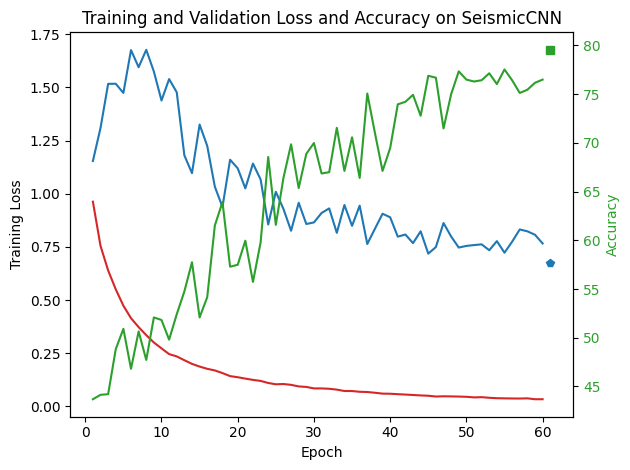

In [41]:
NN = len(loss_time)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.plot(np.arange(1, NN+1), loss_time, color='tab:red')
ax1.plot(np.arange(1, NN+1), val_loss_time, color='tab:blue')
ax1.plot(NN+1, test_loss, 'p', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.plot(np.arange(1, NN+1), val_accuracy_time, color='tab:green')
ax2.plot(NN+1, test_accuracy, 's', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
plt.title("Training and Validation Loss and Accuracy on SeismicCNN")
fig.tight_layout()
plt.show()

In [42]:
model2 = MyCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(
        model2,train_loader,val_loader,test_loader,
        n_epochs=n_epochs,learning_rate=learning_rate,criterion=criterion,
        augmentation=True)

/tmp/ipykernel_3273059/1788766237.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fourier_tensor = torch.fft.fft(torch.tensor(time_series[ichan,:]).float())


[Epoch 10] loss: 0.445 - accuracy: 81.120
[Epoch 20] loss: 0.324 - accuracy: 85.677
[Epoch 30] loss: 0.253 - accuracy: 86.263
[Epoch 40] loss: 0.197 - accuracy: 86.849
[Epoch 50] loss: 0.158 - accuracy: 87.630
[Epoch 60] loss: 0.130 - accuracy: 86.719
test loss: 0.314 and accuracy: 89.583


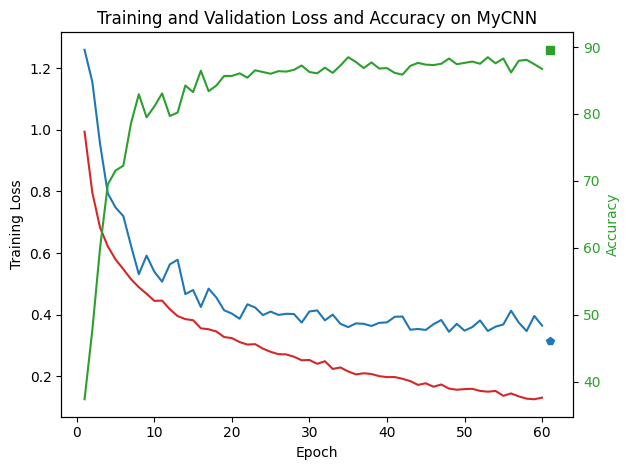

In [43]:
NN = len(loss_time)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.plot(np.arange(1, NN+1), loss_time, color='tab:red')
ax1.plot(np.arange(1, NN+1), val_loss_time, color='tab:blue')
ax1.plot(NN+1, test_loss, 'p', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.plot(np.arange(1, NN+1), val_accuracy_time, color='tab:green')
ax2.plot(NN+1, test_accuracy, 's', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
plt.title("Training and Validation Loss and Accuracy on MyCNN")
fig.tight_layout()
plt.show()

## without augmentation

In [48]:
model3 = MyResCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(model3,
        train_loader,val_loader,test_loader,n_epochs=n_epochs,
        learning_rate=learning_rate,criterion=criterion,augmentation=False)

[Epoch 10] loss: 0.467 - accuracy: 79.492
[Epoch 20] loss: 0.412 - accuracy: 66.602
[Epoch 30] loss: 0.390 - accuracy: 68.424
[Epoch 40] loss: 0.368 - accuracy: 72.721
[Epoch 50] loss: 0.352 - accuracy: 52.083
[Epoch 60] loss: 0.336 - accuracy: 58.333
test loss: 0.904 and accuracy: 61.198


### with augmentation

In [45]:
model3 = MyResCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(model3,
        train_loader,val_loader,test_loader,n_epochs=n_epochs,
        learning_rate=learning_rate,criterion=criterion,augmentation=True)

/tmp/ipykernel_3273059/1788766237.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fourier_tensor = torch.fft.fft(torch.tensor(time_series[ichan,:]).float())


[Epoch 10] loss: 0.497 - accuracy: 51.237
[Epoch 20] loss: 0.453 - accuracy: 54.688
[Epoch 30] loss: 0.430 - accuracy: 59.180
[Epoch 40] loss: 0.411 - accuracy: 56.185
[Epoch 50] loss: 0.413 - accuracy: 58.333
[Epoch 60] loss: 0.385 - accuracy: 54.427
test loss: 1.745 and accuracy: 58.333


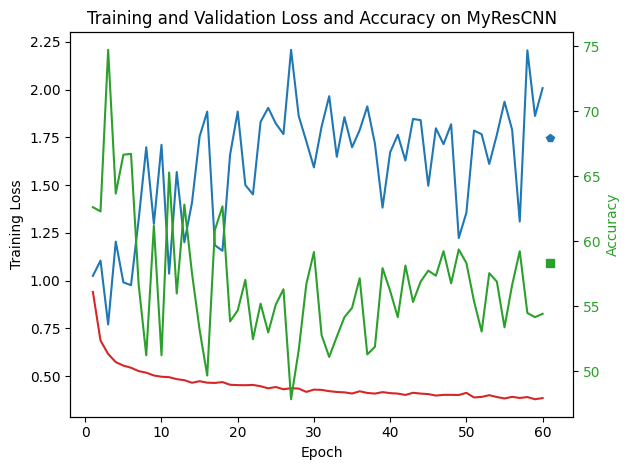

In [46]:
NN = len(loss_time)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.plot(np.arange(1, NN+1), loss_time, color='tab:red')
ax1.plot(np.arange(1, NN+1), val_loss_time, color='tab:blue')
ax1.plot(NN+1, test_loss, 'p', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.plot(np.arange(1, NN+1), val_accuracy_time, color='tab:green')
ax2.plot(NN+1, test_accuracy, 's', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
plt.title("Training and Validation Loss and Accuracy on MyResCNN")
fig.tight_layout()
plt.show()

## Emsemble deep learning

In [ ]:
torch.save(model.state_dict(), 'model_instance_x.pth')

In [ ]:
model_1 = MyCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(
        model_1,train_loader,val_loader,test_loader,
        n_epochs=n_epochs,learning_rate=learning_rate,criterion=criterion,
        augmentation=True)
model_1.load_state_dict(torch.load('model_instance_1.pth'))
model_1.eval()

In [ ]:
model_2 = MyCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(
        model_1,train_loader,val_loader,test_loader,
        n_epochs=n_epochs,learning_rate=learning_rate,criterion=criterion,
        augmentation=True)
model_2._save_to_state_dict(torch.load('model_instance_2.pth'))
model_2.eval()

In [ ]:
model_3 = MyCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(
        model_1,train_loader,val_loader,test_loader,
        n_epochs=n_epochs,learning_rate=learning_rate,criterion=criterion,
        augmentation=True)
model_3._save_to_state_dict(torch.load('model_instance_3.pth'))
model_3.eval()

In [ ]:
model_4 = MyCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(
        model_1,train_loader,val_loader,test_loader,
        n_epochs=n_epochs,learning_rate=learning_rate,criterion=criterion,
        augmentation=True)
model_4._save_to_state_dict(torch.load('model_instance_4.pth'))
model_4.eval()

In [ ]:
model_5 = MyCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(
        model_1,train_loader,val_loader,test_loader,
        n_epochs=n_epochs,learning_rate=learning_rate,criterion=criterion,
        augmentation=True)
model_5._save_to_state_dict(torch.load('model_instance_5.pth'))
model_5.eval()

In [ ]:
model_6 = MyCNN(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(
        model_1,train_loader,val_loader,test_loader,
        n_epochs=n_epochs,learning_rate=learning_rate,criterion=criterion,
        augmentation=True)
model_6._save_to_state_dict(torch.load('model_instance_6.pth'))
model_6.eval()

In [ ]:
def ensemble_predict(models, input):
    # Assuming input is a tensor that can be passed directly to the models
    # And models is a list of model instances
    with torch.no_grad():
        predictions = [model(input) for model in models]
        avg_predictions = torch.mean(torch.stack(predictions), dim=0)
    return avg_predictions

In [ ]:
models = [model_1, model_2,  model_3,  model_4,  model_5,  model_6]  # List of your loaded models

with torch.no_grad(): # Context-manager that disabled gradient calculation.
    # Loop on samples in test set
    total = 0
    correct = 0
    running_test_loss = 0
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.float()
        labels = labels.float()

        outputs = ensemble_predict(inputs)
        running_test_loss += criterion(outputs, labels).item()

        correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()
        total += labels.size(0)


    test_loss = running_test_loss/len(test_loader)
    test_accuracy = 100 * correct / total  
    print('test loss: %.3f and accuracy: %.3f' % ( test_loss,test_accuracy))
